In [1]:
# warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
#Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving store.csv to store.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
#changing a file to dataset
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
store = pd.read_csv(io.BytesIO(uploaded['store.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


A quick glimpse to training data

In [ ]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
train.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
train.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [ ]:
train.shape

(1017209, 9)

A quick glimpse on store data


In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [ ]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [ ]:
store.shape

(1115, 10)

In [ ]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Close Look at Train Data# New Section

Getting rid of closed stores and those who made 0 sales

In [4]:
train= train.drop(train[(train.Open == 0) & (train.Sales == 0)].index)
print("new training set has {} rows".format(train.shape[0]))

new training set has 844392 rows


In [5]:
#reseting index to make sure the data are back to its normal counting
train = train.reset_index(drop = True)

In [ ]:
train.Sales.describe()

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

We can see that there were even some open stores who made 0 sales due to the min on some days we can also drop them.

In [6]:
train= train.drop(train[(train.Open == 1) & (train.Sales == 0)].index)
train = train.reset_index(drop = True)

{'Mean': 6955.959133664481, 'Median': 6369.0}

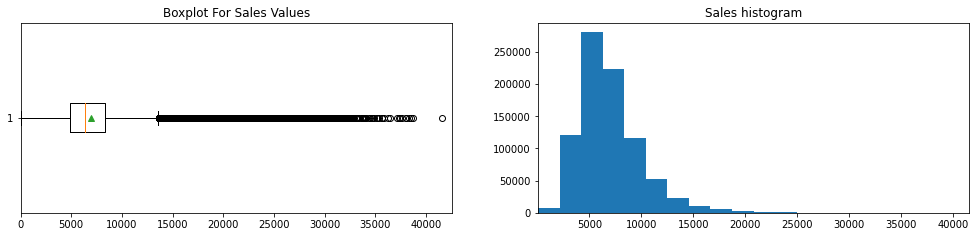

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(train.Sales, showmeans=True,vert=False)
axes[0].set_xlim(0,max(train["Sales"]+1000))
axes[0].set_title('Boxplot For Sales Values')
axes[1].hist(train.Sales, cumulative=False, bins=20)
axes[1].set_title("Sales histogram")
axes[1].set_xlim((min(train.Sales), max(train.Sales)))

{"Mean":np.mean(train.Sales),"Median":np.median(train.Sales)}

In [ ]:
train.Customers.describe()

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

{'Mean': 762.777166253325, 'Median': 676.0}

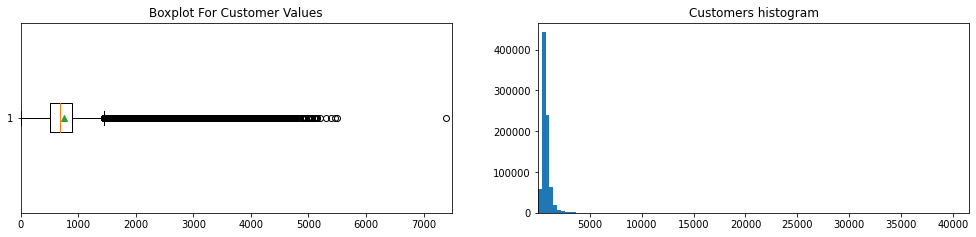

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(train.Customers, showmeans=True,vert=False)
axes[0].set_xlim(0,max(train["Customers"]+100))
axes[0].set_title('Boxplot For Customer Values')
axes[1].hist(train.Customers, cumulative=False, bins=20)
axes[1].set_title("Customers histogram")
axes[1].set_xlim((min(train.Customers), max(train.Sales)))

{"Mean":np.mean(train.Customers),"Median":np.median(train.Customers)}

Checking Correlation between Sales and Customers 

In [ ]:
#using pearson's correlation factor to check correlation
stats.pearsonr(train.Customers, train.Sales)[0]

0.823551720200022

This indicates that there is a strong positive correlation between Sales and Customers! the more the sales the more the customers.

In [ ]:
#checking null values in the train dataset.
train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

We can see that the the columns have got a good fill rate. We don't need to do any change for the train set for now at least

Close look at the store set

In [ ]:
#checking missing values percentage
store.count(0)/store.shape[0] * 100

Store                        100.000000
StoreType                    100.000000
Assortment                   100.000000
CompetitionDistance           99.730942
CompetitionOpenSinceMonth     68.251121
CompetitionOpenSinceYear      68.251121
Promo2                       100.000000
Promo2SinceWeek               51.210762
Promo2SinceYear               51.210762
PromoInterval                 51.210762
dtype: float64

promo2 SinceWeek, SinceYear and primo interval are NULL because of there was no continuation in promotions for those stores.

we have to deal with missing values for CompetitionOpenSinceMonth and CompetitionOpenSinceYear


**Filling missing values one by one**

1. CompetionDistance

In [ ]:
store[pd.isnull(store.CompetitionDistance)] 
#only 3 rows misses data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [7]:
#filling CompetitionDistance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)


2. CompetitionOpenSince and CompetionOpenSinceYear

Since we have no information whatsoever on those missing values and no accurate way of filling those values.

A creative way could be to apply a multilabel classification algorithm and train on the non Nan fields and then predict what could be most probably the month and year for those fields. But this approach is computationally too long.

So for this purpose those fields are going to be assigned to 0 .


In [8]:
store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store.CompetitionOpenSinceYear.fillna(0,inplace=True)

3) Promo2SinceWeek, Promo2SinceYear and PromoInterval


In [ ]:
#checking cells where the later columns are null
# store[pd.isnull(store.Promo2SinceWeek)]
# store[pd.isnull(store.Promo2SinceWeek)& (store.Promo2==0)]
# they are null where promo2 is 0 

Having no promotion means those fields have to be 0 as well since they are linked to Promo2. to mean there is no continuation in promotion

In [9]:
store.Promo2SinceWeek.fillna(0,inplace=True)
store.Promo2SinceYear.fillna(0,inplace=True)
store.PromoInterval.fillna(0,inplace=True)

In [10]:
store.count(0)/store.shape[0] * 100

Store                        100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

All is well now we can merge our sets.

we use left join to join train to store dataset because you want to make sure you have all events even if some of them don't have their store information ( which shouldn't happen)

In [11]:
df_train_store = pd.merge(train, store, how = 'left', on = 'Store')
 
print ("The Train_Store dataset has {} Rows and {} Variables".format(str(df_train_store.shape[0]),str(df_train_store.shape[1]))) 

The Train_Store dataset has 844338 Rows and 18 Variables


**Seasonability sales and Customer behavior**

In [91]:
#function to plot sales and purchase trends
def plot_trends(data, column):
    data_sales = pd.concat([data[column],data['Date']], axis = 1)
    data_sales = data_sales.set_index('Date')
    fig, ax = plt.subplots(figsize= (18,8))
    month_plots = data_sales.resample('M').mean()
    ax.plot(month_plots)
    ax.set(xlabel = "date", ylabel = "Total Sales per month", title = "Monthly Sales Trend")
    plt.xticks(rotation = 45, fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.show()

In [ ]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [ ]:
plot_trends(df_train_store,'Sales')

**Store Type Analysis**

for well analyzing the stores we need to find the sales per customers,
 and see which one makes use of its customers to spend the most on average

In [12]:
#defining a sales per customer feature
df_train_store['SalesperCustomer']=df_train_store['Sales']/df_train_store['Customers']

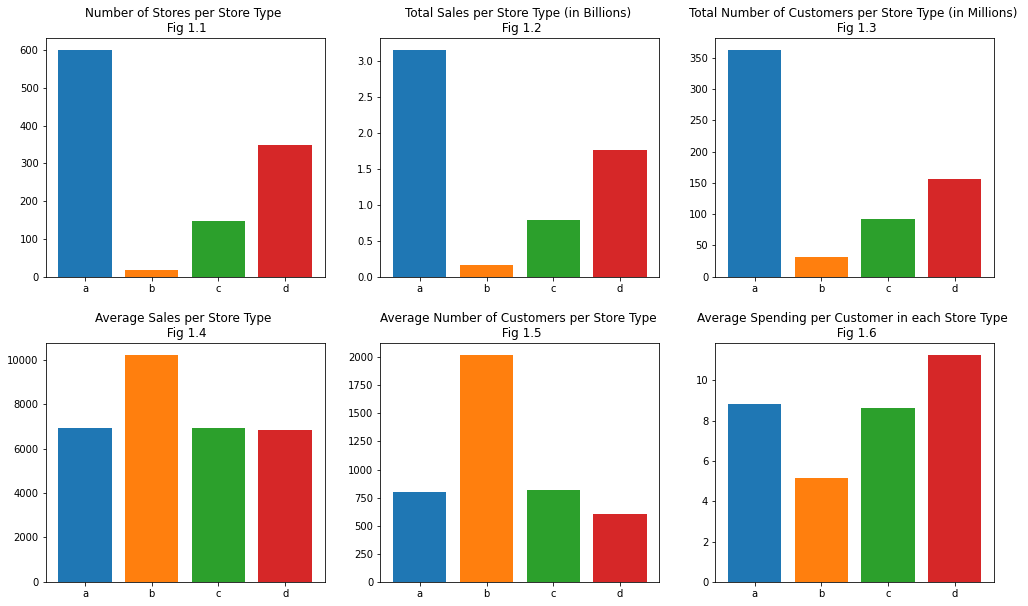

In [ ]:
#visualizing store information for analysis

fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)

axes[0,0].bar(store.groupby(by="StoreType").count().Store.index,store.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")
axes[0,1].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")
axes[0,2].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")
axes[1,0].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")
axes[1,1].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")
axes[1,2].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")
plt.show()


**Findings**

1. From these above graphs we can see that the the store type **a** has leads other stores in terms of branches, Sales and Customers.

2. Although Store **b** has few branches, it experienced a big average of average sales and customers.

3. Suprisingly store **d** is the one which saw the highest average spending
 on customers, means the customers buy many items may be because there is no other shops which sells similar items(long distance to the competitors)

**Assortments Analysis**
Intersted in finding the store type with its assortments

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

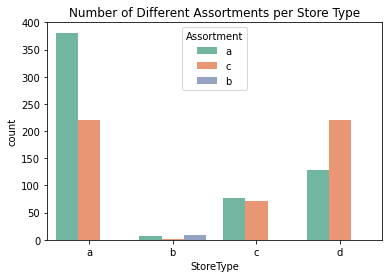

In [ ]:
StoretypeXAssortment = sns.countplot(x="StoreType",hue="Assortment",order=
                                     ["a","b","c","d"], data=store,palette=sns.color_palette("Set2", n_colors
                                      =3)).set_title("Number of Different Assortments per Store Type")
store.groupby(by=["StoreType","Assortment"]).Assortment.count()

**Findings** 

1.From the above graph we can clearly se that many stores are in assortment **a**
and **c** (basic and extended things).

2. Captivatingly the store type **d** which has the highest customer spendings
saw a highest **c** (extended things) assortment. this is most probably the reason of high customer spendings.

3. Lastly the store type **b** is the only one which saw all the 3 assortment **b** which means extra.

**Promotion.**
 Interested in seeing how promotions affected sales over three years.
This allow us first to see the impact of promotion and as well to see the evolution of sales over specific years (so trends in a given year).


In [13]:
#change the date column to datetime format and extract from it month and year
df_train_store['Date'] = pd.to_datetime(df_train_store['Date'], infer_datetime_format=True) 
df_train_store['Month']=df_train_store.Date.dt.month
df_train_store['Year']=df_train_store.Date.dt.year


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


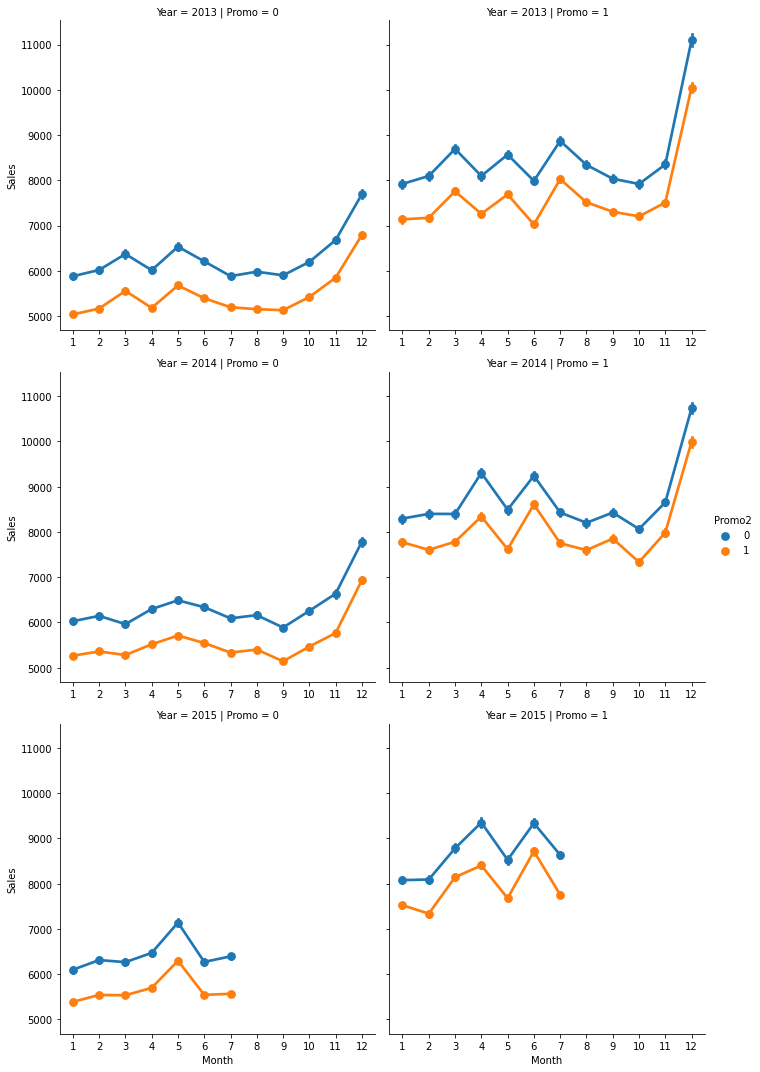

In [ ]:
sns.factorplot(data = df_train_store, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
              ,sharex=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


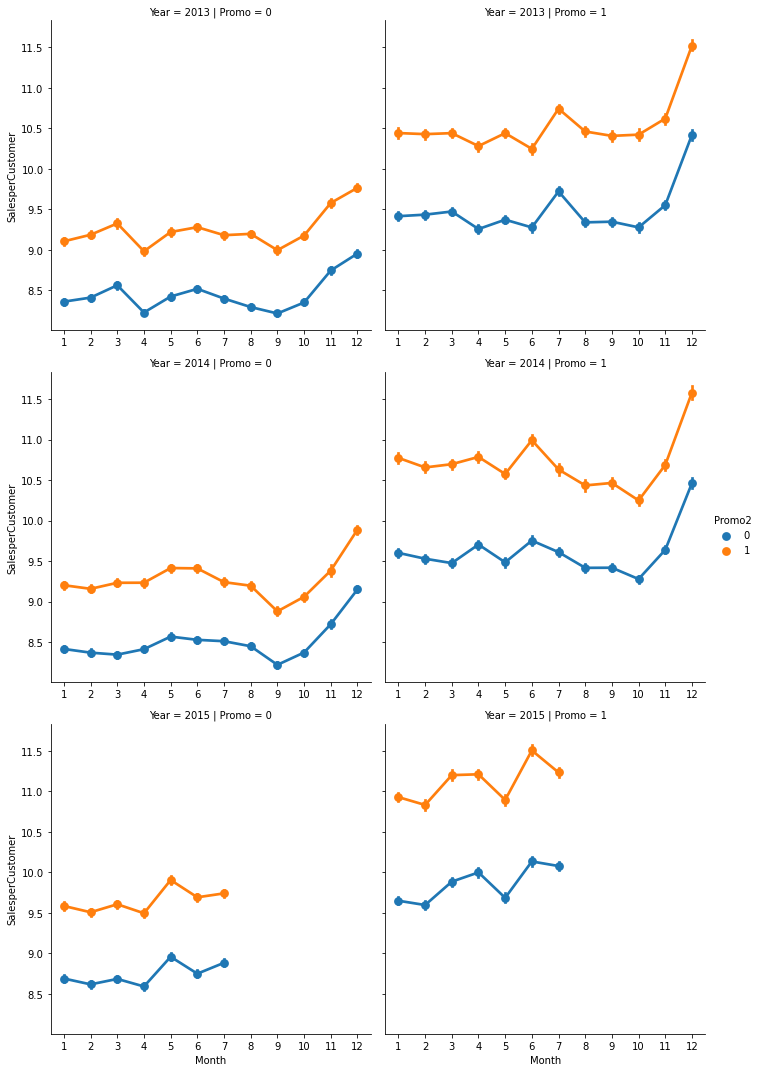

In [ ]:
sns.factorplot(data = df_train_store, x ="Month", y = "SalesperCustomer", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
              ,sharex=False)

**Findings:**

1.We see the dramatic change when we compare having promotion Promo=1 to not having promotion Promo=0 and can conclude that a store that have promotion on a given day changes its amount of sales considerably.

2.Surprisingly, checking more  at the Promo2 variable (indicating a continuos promotion blue vs orange) we see that in general when there is no consecutive promotion stores tend to sell more then with consecutive promotion. 

3.If we look over the years,there is a slight increase Year over Year and we actually see a very similair pattern in the months over the years with major spikes first around Easter period in March and April then in Summer in May,June and July and then finally around the Christmas period in November and December.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


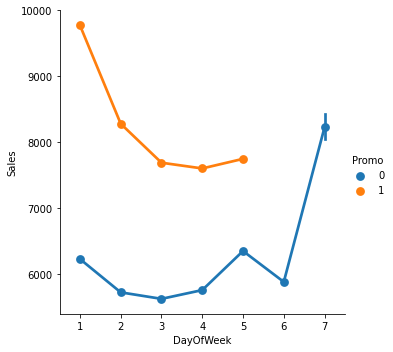

In [ ]:
#promotion impact in weekdays
sns.factorplot(data = df_train_store, x ="DayOfWeek", y = "Sales",
                hue='Promo'
              ,sharex=False)

After attempting to look at Sales behaviour in a week over the Years and over the months, i concluded that the pattern doesn't change, which means all the time there is a peak on Mondays with promotions, a tiny peak on Friday before the weekend and a big peak on Sunday because of closed stores.

**Competition Distance**

In [86]:
dist_sales = df_train_store[['Sales', 'CompetitionDistance']]
dist_sales = dist_sales.sort_values(by= 'CompetitionDistance')
dist_sales.head()

,Sales,CompetitionDistance
528238,7065,20.0
580011,4451,20.0
320656,4075,20.0
161079,4838,20.0
470412,3858,20.0


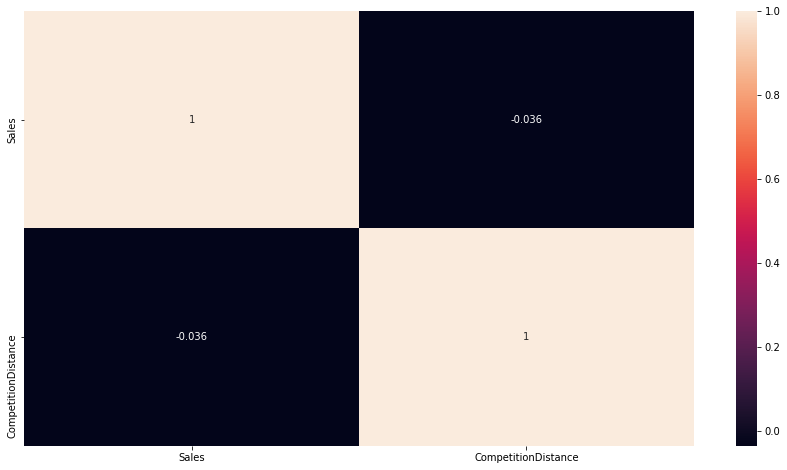

In [87]:
#correlation between sales and distance to store competitor
corr1=dist_sales[['Sales', 'CompetitionDistance']].corr()
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr1,annot=True,
            xticklabels=corr1.columns.values,
            yticklabels=corr1.columns.values)

Clearly there is a strong positive  correlation between store sales and distance to its competitor. The longer the distance the bigger the sales.

In [14]:
#extracting day  from the data column
df_train_store['Day']=df_train_store.Date.dt.day


In [15]:
#deleting date column as we hawe month, year and day from it
del df_train_store["Date"]

Changing some object columns to numerical categories b first making sure there are no Nan values from them.

In [ ]:
#making sure there are no NAN values
df_train_store['StoreType'].isnull().any(),df_train_store['Assortment'].isnull().any(),df_train_store['StateHoliday'].isnull().any()
#No Null values we can proceed with the transformation

(False, False, False)

In [16]:
df_train_store['StateHoliday'] = df_train_store['StateHoliday'].astype('category')
df_train_store['Assortment'] = df_train_store['Assortment'].astype('category')
df_train_store['StoreType'] = df_train_store['StoreType'].astype('category')
df_train_store['PromoInterval']= df_train_store['PromoInterval'].astype('category')

In [17]:
df_train_store['StateHoliday_cat'] = df_train_store['StateHoliday'].cat.codes
df_train_store['Assortment_cat'] = df_train_store['Assortment'].cat.codes
df_train_store['StoreType_cat'] = df_train_store['StoreType'].cat.codes
df_train_store['PromoInterval_cat'] = df_train_store['PromoInterval'].cat.codes

In [18]:
df_train_store['StateHoliday_cat'] = df_train_store['StateHoliday_cat'].astype('float')
df_train_store['Assortment_cat'] = df_train_store['Assortment_cat'].astype('float')
df_train_store['StoreType_cat'] = df_train_store['StoreType_cat'].astype('float')
df_train_store['PromoInterval_cat'] = df_train_store['PromoInterval_cat'].astype('float')
df_train_store.dtypes

Store                           int64
DayOfWeek                       int64
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                 category
SchoolHoliday                   int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                          int64
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
SalesperCustomer              float64
Month                           int64
Year                            int64
Day                             int64
StateHoliday_cat              float64
Assortment_cat                float64
StoreType_cat                 float64
PromoInterval_cat             float64
dtype: object

**Training Random Forest Regressor**

 One of the advantages of Random forest runtimes is that, it is quite fast, and they are able to deal with unbalanced and missing data.


**Some feature engineering **

Since the competition variables CompetitionOpenSinceYear and CompetitonnOpenSinceMonth have the same  meaning, merging them into one variable  makes easier for the algorithm to understand the pattern and creates less branches and thus complex trees.

In [19]:
#Creating new column from the above two
df_train_store['CompetitionOpenSince'] = np.where((df_train_store['CompetitionOpenSinceMonth']==0) & (df_train_store['CompetitionOpenSinceYear']==0) , 
                                                  0,(df_train_store.Month - df_train_store.CompetitionOpenSinceMonth) + 
                                                  (12 * (df_train_store.Year - df_train_store.CompetitionOpenSinceYear)) )

In [20]:
#now that CompetitionOpenSince is created 
#we can get rid of `CompetitionOpenSinceYear` and `CompeitionOpenSinceMonth`
del df_train_store['CompetitionOpenSinceYear']
del df_train_store['CompetitionOpenSinceMonth']

In [21]:
#Changing stateholiday column to a binary variable
df_train_store["is_holiday_state"] = df_train_store['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})

In [22]:
#getting rid of stateholiday variable
del df_train_store['StateHoliday_cat']

In [23]:
#changing categorical variables into dummies 
df_train_store=pd.get_dummies(df_train_store, columns=["Assortment", "StoreType","PromoInterval"],
                              prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])

In [24]:

del df_train_store['Assortment_cat']
del df_train_store['StoreType_cat']
del df_train_store['PromoInterval_cat']
df_train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'SalesperCustomer', 'Month',
       'Year', 'Day', 'CompetitionOpenSince', 'is_holiday_state',
       'is_Assortment_a', 'is_Assortment_b', 'is_Assortment_c',
       'is_StoreType_a', 'is_StoreType_b', 'is_StoreType_c', 'is_StoreType_d',
       'is_PromoInteval_0', 'is_PromoInteval_Feb,May,Aug,Nov',
       'is_PromoInteval_Jan,Apr,Jul,Oct', 'is_PromoInteval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [54]:
df_test.fillna(1, inplace = True)
df_test_store = pd.merge(df_test, store, how = 'left', on = 'Store')
print ("The Test_Store dataset has {} Rows and {} Variables".format(str(df_test_store.shape[0]),str(df_test_store.shape[1]))) 

#change the date column to datetime format and extract from it month and year
df_test_store['Date'] = pd.to_datetime(df_test_store['Date'], infer_datetime_format=True)
df_test_store['Month']=df_test_store.Date.dt.month
df_test_store['Year']=df_test_store.Date.dt.year
df_test_store['Day']=df_test_store.Date.dt.day

df_test_store['StateHoliday'] = df_test_store['StateHoliday'].astype('category')
df_test_store['Assortment'] = df_test_store['Assortment'].astype('category')
df_test_store['StoreType'] = df_test_store['StoreType'].astype('category')
df_test_store['PromoInterval']= df_test_store['PromoInterval'].astype('category')
df_test_store['StateHoliday_cat'] = df_test_store['StateHoliday'].cat.codes
df_test_store['Assortment_cat'] = df_test_store['Assortment'].cat.codes
df_test_store['StoreType_cat'] = df_test_store['StoreType'].cat.codes
df_test_store['PromoInterval_cat'] = df_test_store['PromoInterval'].cat.codes
df_test_store['StateHoliday_cat'] = df_test_store['StateHoliday_cat'].astype('float')
df_test_store['Assortment_cat'] = df_test_store['Assortment_cat'].astype('float')
df_test_store['StoreType_cat'] = df_test_store['StoreType_cat'].astype('float')
df_test_store['PromoInterval_cat'] = df_test_store['PromoInterval_cat'].astype('float')
df_test_store['CompetitionOpenSince'] = np.where((df_test_store['CompetitionOpenSinceMonth']==0) & (df_test_store['CompetitionOpenSinceYear']==0) , 0,(df_test_store.Month - df_test_store.CompetitionOpenSinceMonth) + 
                                       (12 * (df_test_store.Year - df_test_store.CompetitionOpenSinceYear)) )



df_test_store["is_holiday_state"] = df_test_store['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})




df_test_store=pd.get_dummies(df_test_store, columns=["Assortment", "StoreType","PromoInterval"], prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])

The Test_Store dataset has 41088 Rows and 17 Variables


In [26]:
del df_test_store["Date"]
del df_test_store['CompetitionOpenSinceYear']
del df_test_store['CompetitionOpenSinceMonth']
del df_test_store['StateHoliday_cat']
del df_test_store['Assortment_cat']
del df_test_store['StoreType_cat']
del df_test_store['PromoInterval_cat']
del df_test_store['StateHoliday']
del df_train_store['StateHoliday']

In [27]:
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean( (y - yhat)**2 ))
    return rmspe

In [28]:
features = df_train_store.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1) 
#a rule of thumb is to transform my target value to log if i see the values are very dispersed which is the case
#and then of course revert them with np.exp to their real values
targets=np.log(df_train_store.Sales)

In [42]:
X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, targets, test_size=0.20, random_state=15)
#print ("Training and testing split was successful.")
X_train.is_holiday_state.fillna(0,inplace=True)
X_train_test.is_holiday_state.fillna(0,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [44]:
 X_train_test.isna().sum()

Store                               0
DayOfWeek                           0
Open                                0
Promo                               0
SchoolHoliday                       0
CompetitionDistance                 0
Promo2                              0
Promo2SinceWeek                     0
Promo2SinceYear                     0
Month                               0
Year                                0
Day                                 0
CompetitionOpenSince                0
is_holiday_state                    0
is_Assortment_a                     0
is_Assortment_b                     0
is_Assortment_c                     0
is_StoreType_a                      0
is_StoreType_b                      0
is_StoreType_c                      0
is_StoreType_d                      0
is_PromoInteval_0                   0
is_PromoInteval_Feb,May,Aug,Nov     0
is_PromoInteval_Jan,Apr,Jul,Oct     0
is_PromoInteval_Mar,Jun,Sept,Dec    0
dtype: int64

In [45]:
rfr = RandomForestRegressor(n_estimators=10, 
                             criterion='mse', 
                             max_depth=5, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4,
                             random_state=31, 
                             verbose=0, 
                             warm_start=False)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=4, oob_score=False,
                      random_state=31, verbose=0, warm_start=False)

In [46]:
#training using cross validation set
rfr_val=RandomForestRegressor(n_estimators=128, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, #setting n_jobs to 4 makes sure you're using the full potential of the machine you're running the training on
                             random_state=35, 
                             verbose=0, 
                             warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

In [47]:
yhat=model_RF_test.predict(X_train_test)

(array([2.0000e+01, 2.3100e+02, 9.3200e+02, 5.9060e+03, 2.8602e+04,
        7.3568e+04, 4.7568e+04, 1.0021e+04, 1.9310e+03, 8.9000e+01]),
 array([ 6.51439833,  6.91015948,  7.30592062,  7.70168176,  8.0974429 ,
         8.49320404,  8.88896518,  9.28472632,  9.68048746, 10.0762486 ,
        10.47200974]),
 <a list of 10 Patch objects>)

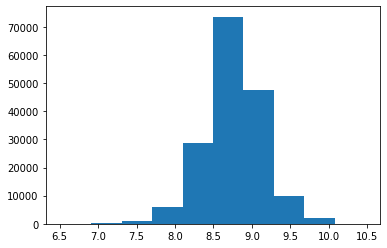

In [48]:
plt.hist(yhat)

In [49]:
error=rmspe(y_train_test,yhat)
error

0.1611521960204134

0.16... is trustworthy to be sure about the predictions of our model.

**Feature Importance**

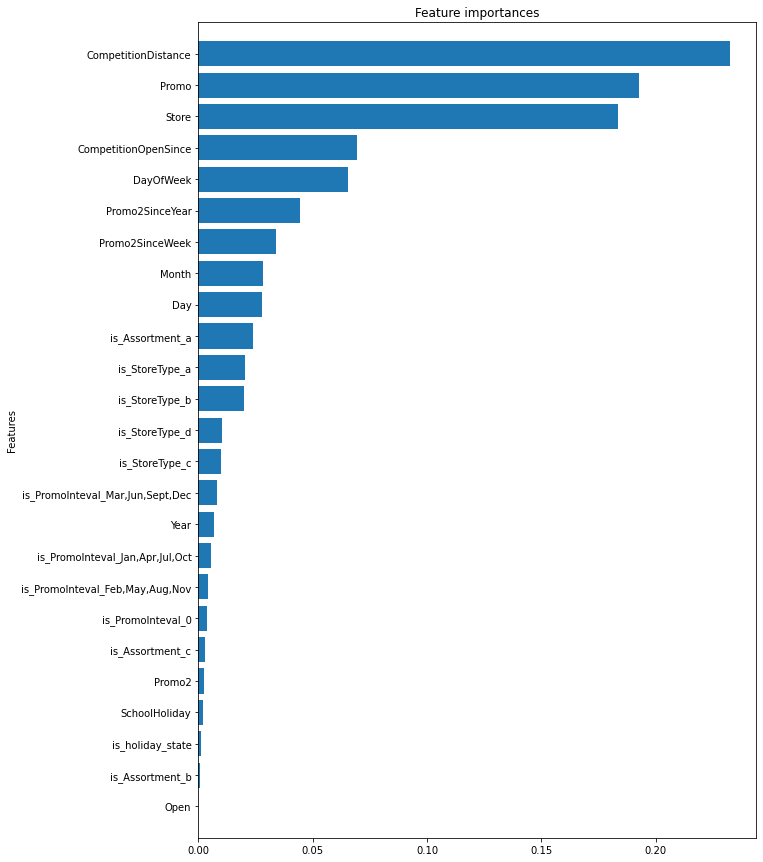

In [50]:
importances = rfr_val.feature_importances_
std = np.std([rfr_val.feature_importances_ for tree in rfr_val.estimators_],
             axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette())
# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest

plt.figure(figsize=(10,15))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [71]:
#predicting on a test set
df_test_store1 = df_test_store.drop(['Id', 'Date'],axis=1)
df_test_store1.dtypes
# yhat1= model_RF_test.predict(df_test_store1)

# preds= pd.DataFrame({'Id': df_test_store['Id'], 
#                           'Sales': np.exp(yhat1)})

Store                                  int64
DayOfWeek                              int64
Open                                 float64
Promo                                  int64
StateHoliday                        category
SchoolHoliday                          int64
CompetitionDistance                  float64
CompetitionOpenSinceMonth            float64
CompetitionOpenSinceYear             float64
Promo2                                 int64
Promo2SinceWeek                      float64
Promo2SinceYear                      float64
Month                                  int64
Year                                   int64
Day                                    int64
StateHoliday_cat                     float64
Assortment_cat                       float64
StoreType_cat                        float64
PromoInterval_cat                    float64
CompetitionOpenSince                 float64
is_holiday_state                    category
is_Assortment_a                        uint8
is_Assortm

 **Training XGboost Model**

In [72]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [73]:
xg_reg.fit(X_train,y_train)

[10:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

(array([6.8900e+02, 1.7516e+04, 5.5008e+04, 6.7365e+04, 2.5936e+04,
        1.6620e+03, 3.6700e+02, 1.9000e+02, 4.4000e+01, 9.1000e+01]),
 array([5.597694 , 5.686982 , 5.7762704, 5.865559 , 5.9548473, 6.0441356,
        6.133424 , 6.222712 , 6.3120008, 6.401289 , 6.490577 ],
       dtype=float32),
 <a list of 10 Patch objects>)

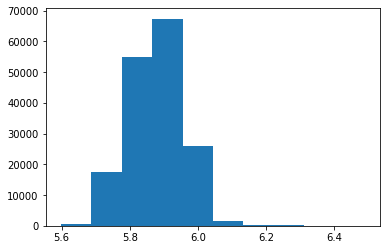

In [75]:
#prediciting and plotting the predictions
preds = xg_reg.predict(X_train_test)
plt.hist(preds)

In [76]:
error1=rmspe(y_train_test,preds)
error1

2.9060216363762934

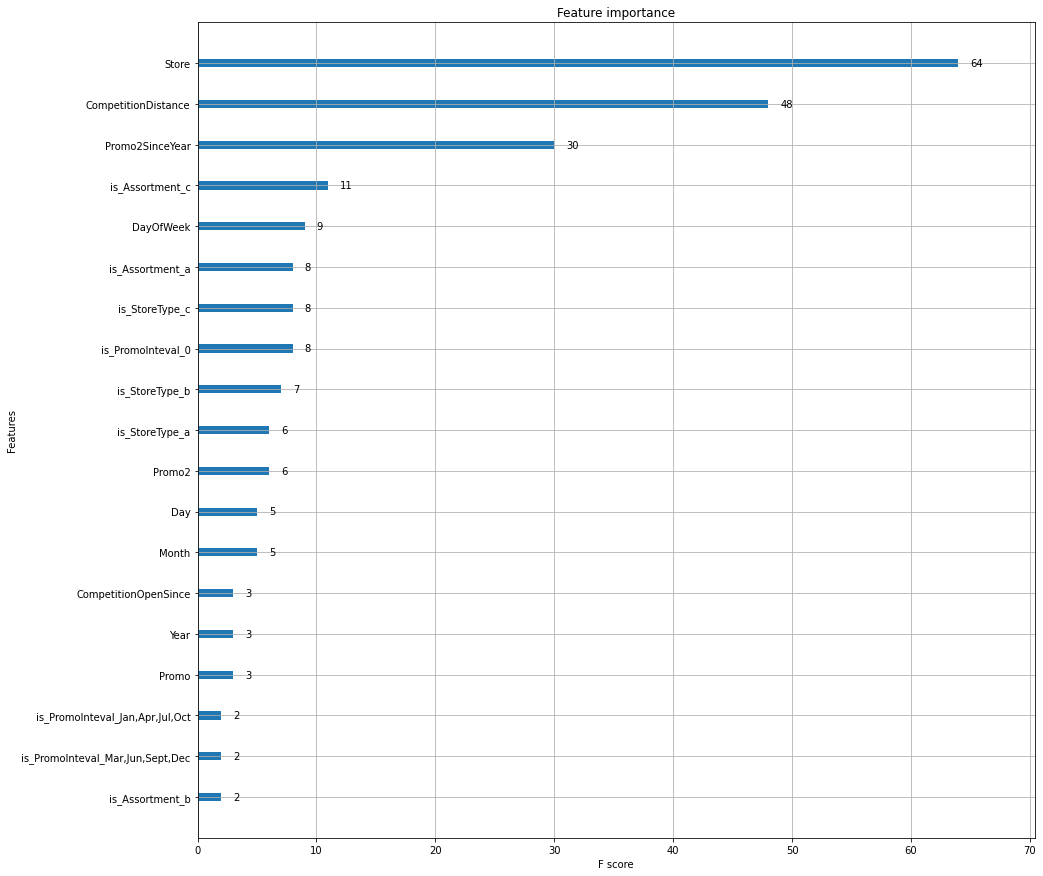

In [81]:


xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [25, 25]
plt.show()

 when looking the loss function of the two models it is 
 Clearly seen that The Random regressor model perfom better with an error of **0.1611521960** whereas  XGBoost has a big error of **2.9060216363762934**. 

So I will save(serialize) the random forest regressor model for future predictions

In [84]:
import pickle
#model saved in timestamp format
filename = '21-8-2020-13-57.pkl'
pickle.dump(rfr_val, open(filename, 'wb'))